# Data:

In [79]:
import pickle
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [80]:
# Indicate dataframes to import.
list_dfs = ['pickled_conala_mined_df', 'pickled_conala_train_df', 'pickled_conala_test_df',
           'conala_train_bag_df', 'conala_mined_bag_df', 'combined_bag_df']

In [81]:
%time
# Load all data in list_dfs
data = {}
for df in list_dfs:
    dbfile = open(df, 'rb')      
    contents = pickle.load(dbfile)
    data[df] = contents
    dbfile.close()

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.01 µs


In [82]:
data.keys()

dict_keys(['pickled_conala_mined_df', 'pickled_conala_train_df', 'pickled_conala_test_df', 'conala_train_bag_df', 'conala_mined_bag_df', 'combined_bag_df'])

In [83]:
df = data['combined_bag_df']

## Word2Vec

For Word2Vec, we need a list of all the sentences which will be transformed in it. So this will have to be done for both intent, and snippet. We can assemble this by combining the `conala_train_df` and the `conala_mined_df`

In [106]:
conala_train_df = data["pickled_conala_train_df"]
conala_mined_df = data["pickled_conala_mined_df"]

In [111]:
# concatenate the two dfs.
df = pd.concat([conala_train_df, conala_mined_df], ignore_index=True)

In [116]:
# Peek
df

,intent,rewritten_intent,snippet,question_id,parent_answer_post_id,prob,id
0,How to convert a list of multiple integers int...,Concatenate elements of a list 'x' of multiple...,"sum(d * 10 ** i for i, d in enumerate(x[::-1]))",41067960,NaN,NaN,NaN
1,How to convert a list of multiple integers int...,convert a list of integers into a single integer,"r = int(''.join(map(str, x)))",41067960,NaN,NaN,NaN
2,how to convert a datetime string back to datet...,convert a DateTime string back to a DateTime o...,datetime.strptime('2010-11-13 10:33:54.227806'...,4170655,NaN,NaN,NaN
3,Averaging the values in a dictionary based on ...,get the average of a list values for each key ...,"[(i, sum(j) / len(j)) for i, j in list(d.items...",29565452,NaN,NaN,NaN
4,zip lists in python,"zip two lists `[1, 2]` and `[3, 4]` into a lis...","zip([1, 2], [3, 4])",13704860,NaN,NaN,NaN
...,...,...,...,...,...,...,...
5759,How to convert datetime to string in python in...,NaN,{{(item.date | date): 'Y M d'}},794995,795000.0,0.500243,794995_795000_0
5760,Delete column from pandas DataFrame,NaN,"df = df.drop('column_name', 1)",13411544,18145399.0,0.500193,13411544_18145399_2
5761,How to get a list which is a value of a dictio...,NaN,"reverse_d = {value: key for key, values in lis...",40584186,40584271.0,0.500171,40584186_40584271_0
5762,Cross-platform addressing of the config file,NaN,config_file = os.path.expanduser('~/foo.ini'),3227624,3227931.0,0.500164,3227624_3227931_0


In [120]:
# Create a list of the text in intent field. (Note this is NOT using the 
# rewritten intent in the training data.)
intent_list = list(df["intent"])

# Create a list of the code snippets in the data. 
snippet_list = list(df["snippet"])

In [121]:
# Check
print(intent_list[:10])
print(snippet_list[:10])

['How to convert a list of multiple integers into a single integer?', 'How to convert a list of multiple integers into a single integer?', 'how to convert a datetime string back to datetime object?', 'Averaging the values in a dictionary based on the key', 'zip lists in python', 'Prepend the same string to all items in a list', 'regex for repeating words in a string in Python', 'Normalizing a pandas DataFrame by row', 'swap values in a tuple/list inside a list in python?', 'swap values in a tuple/list inside a list in python?']
['sum(d * 10 ** i for i, d in enumerate(x[::-1]))', "r = int(''.join(map(str, x)))", "datetime.strptime('2010-11-13 10:33:54.227806', '%Y-%m-%d %H:%M:%S.%f')", '[(i, sum(j) / len(j)) for i, j in list(d.items())]', 'zip([1, 2], [3, 4])', "['hello{0}'.format(i) for i in a]", "re.sub('(?<!\\\\S)((\\\\S+)(?:\\\\s+\\\\2))(?:\\\\s+\\\\2)+(?!\\\\S)', '\\\\1', s)", 'df.div(df.sum(axis=1), axis=0)', 'map(lambda t: (t[1], t[0]), mylist)', '[(t[1], t[0]) for t in mylist]']

Now we need to get each unique word in the text, and for the code, each unique char.

In [123]:
# Get unique words in text
intent_tokens = set()
    
for intent in tqdm(intent_text):
    for word in intent.split(" "):
        intent_tokens.add(word)

num_intent_tokens = len(intent_tokens)
intent_tokens

100%|██████████| 5764/5764 [00:00<00:00, 361088.65it/s]


{'decoding',
 '',
 'href',
 'overplot',
 "column's",
 'logged',
 'Google',
 "'",
 'Update,',
 'Drawing',
 'resources',
 'savepoints',
 'networkx',
 'year?',
 'Rotate',
 'rules',
 'comparing',
 'Dictionary',
 '(Django)',
 'due',
 'urllib2?',
 'test',
 'animation',
 'complex',
 'project?',
 'Count',
 'backslashes',
 'Windows,',
 'requests',
 'ascii?',
 "matplotlib's",
 'Speed',
 'numeric',
 'Sum',
 'field',
 'contiguous',
 'N-dimensional',
 'group?',
 'Pivot',
 'matplotlib,',
 'correlating',
 'columns',
 'Faster',
 'escape',
 'if',
 'comma-separated',
 'provided',
 'want',
 'mongoengine',
 'executing',
 'any',
 'mongoengine?',
 'range',
 'trying',
 'hierarchy',
 'itertools',
 'standardization',
 'DataFrame',
 'combinations',
 'detect',
 'bower',
 'joining',
 'Colormaps',
 'contents',
 'Duplicating',
 'architect',
 'cropped',
 'Blueprints,',
 'this?',
 'mathematical',
 '(python',
 'symbols',
 'chrome',
 'class?',
 'bins',
 'colors',
 'front',
 'to/from',
 'mean',
 'one?',
 'pandas:',
 'fr

In [125]:
len(intent_text)

5764

In [124]:
num_intent_tokens

3658

## PCA Dimension Reduction

In [84]:
from sklearn.decomposition import PCA

In [85]:
num_pcs = 200
# Instantiate
myPCA = PCA(n_components=200)
# Fit
myPCA.fit(df)

PCA(n_components=200)

In [86]:
expl_var = myPCA.explained_variance_ratio_
expl_var_cumulative = myPCA.explained_variance_ratio_.cumsum()

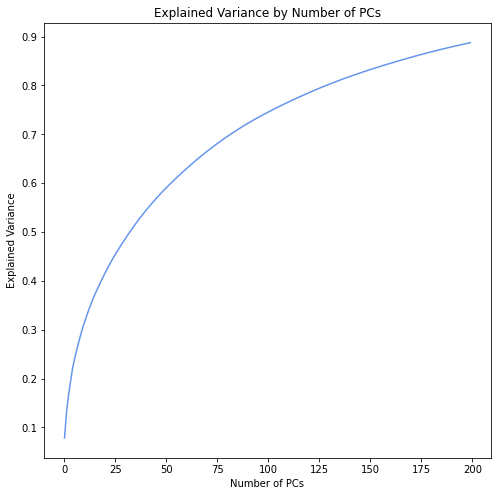

In [88]:
plt.figure(figsize=(8,8))
plt.plot(range(num_pcs), expl_var_cumulative, color='cornflowerblue')
plt.title("Explained Variance by Number of PCs")
plt.xlabel("Number of PCs")
plt.ylabel("Explained Variance")
plt.show()

There's a diminishing return in the explained variance with respect to the number of PCs.
But it's heartening that the explained variance begins with a steep increase in variance explained. 
Let's take the explained variance thresholde to be 0.8

In [89]:
# Finding the number of PCs for 0.8 explained var.
num_PCs = np.argmax(expl_var_cumulative > 0.8)
num_PCs

129

In [90]:
# Refitting with 129 PCs

# Instantiate
myPCA = PCA(n_components=num_PCs)
# Fit
myPCA.fit(df)
# Transform
df_PC = myPCA.transform(df)

In [91]:
df_PC

array([[ 8.30211826e-01,  2.28719438e-02, -6.95820656e-02, ...,
         4.14308825e-02,  1.02270580e-02,  3.19598971e-03],
       [-4.47927722e-01,  9.07108512e-01,  1.58991298e-01, ...,
         1.68376579e-02,  2.53333850e-02, -8.79782729e-02],
       [ 8.63373126e-01, -1.66304769e-01,  6.69454493e-02, ...,
        -1.33635689e-02, -3.37607854e-03,  1.14923377e-03],
       ...,
       [ 1.79547904e+00, -2.98582241e-02,  2.12011670e-01, ...,
        -4.07769826e-03,  7.68801444e-03, -2.25761341e-03],
       [-2.49460231e-01, -1.97708778e-01, -2.90216452e-01, ...,
         2.25852624e-02, -4.81020712e-03,  1.50668864e-02],
       [-2.56893639e-01, -1.48228207e-01, -2.26475296e-01, ...,
         4.14762563e-02, -4.04649726e-02,  2.73498383e-02]])

In [92]:
%%time
from sklearn.cluster import AgglomerativeClustering
agg_clus = AgglomerativeClustering(n_clusters=3, linkage='average').fit(df_PC)

CPU times: user 3.29 s, sys: 187 ms, total: 3.47 s
Wall time: 4.37 s


In [93]:
agg_clus.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [94]:
np.unique(agg_clus.labels_, return_counts=True)

(array([0, 1, 2]), array([5759,    1,    3]))

In [95]:
from sklearn.metrics.cluster import silhouette_score

silhouette_score(df, agg_clus.labels_)

0.5075142113800785

## TF-IDF

This did not accomplish anything meaningful.

In [77]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [97]:
tfidf = TfidfVectorizer().fit(df)
df_tfidf = tfidf.transform(df)

df_tfidf = pd.DataFrame(columns=tfidf.get_feature_names(), data=df)
display(df_tfidf)

,01,10,100,11,12,13,15,16,20,2011,...,world,write,writing,www,xc3,xor,year,zero,zeros,zip
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5759,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5760,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5761,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5762,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [99]:
df_tfidf.sum()

01       14
10       27
100      13
11       13
12       16
         ..
xor       5
year     22
zero     22
zeros     8
zip      18
Length: 434, dtype: int64

In [100]:
df.sum()

01       14
10       27
100      13
11       13
12       16
         ..
xor       5
year     22
zero     22
zeros     8
zip      18
Length: 434, dtype: int64

So this vectorization is equivalent to the bag of words. Not necessary, and does not improve anything.